In [1]:
import pandas as pd
import numpy as np
from copy import copy, deepcopy
from ClearskyModelFunction import *

# Ground level Data Processing

In [2]:
Delhi_NCRData = pd.read_csv('clear_sky_model_delhiNCR.csv')
Latitude = 28.425
Longitude = 77.155
Elevation = 256

In [3]:
def getGfilteredData(data):
    data = data.sort_values(by = ['Year', 'Month', 'Day'])
    data = data.reset_index(drop = True)
    ts = []
    dni_sum = list(data[data.columns[pd.Series(data.columns).str.startswith('DNI')]].sum(axis = 1, skipna = True))
    ghi_sum = list(data[data.columns[pd.Series(data.columns).str.startswith('GHI')]].sum(axis = 1, skipna = True))
    
    for i in range(len(data)):
        ts.append(pd.Timestamp(year = data['Year'][i], month = data['Month'][i], day = data['Day'][i], 
                hour = data['Hour'][i], minute = data['Minute'][i]) - pd.Timedelta("5 hours 30 minutes")) 
        
    FilteredData = pd.DataFrame(list(zip(ts,list(data['Year']),list(data['Month']),list(data['Day']),
                                         list(data['Precip water (cm)']), list(data['hr mean ambient tmp']),
                                         list(data['Wind speed (M/s)']),dni_sum,ghi_sum)),
            columns =['TimeStamp','Year', 'Month', 'Day','Precip water (cm)','hr mean ambient tmp',
                      'Wind speed (M/s)','DNI','GHI'])

    FilteredData = FilteredData[(FilteredData['Precip water (cm)'] != 0) & 
                    (FilteredData['hr mean ambient tmp'] != 0) & (FilteredData['Wind speed (M/s)'] != 0) & 
                                (FilteredData['DNI'] != 0) & (FilteredData['GHI'] != 0)]
    
    
    FilteredData['DNI'] = FilteredData['DNI']*10
    FilteredData['GHI'] = FilteredData['GHI']*10
    
    FilteredData['Date'] = FilteredData['TimeStamp'].apply(lambda x: "%d-%d-%d" % (x.year, x.month, x.day))
    
    FilteredData = FilteredData.reset_index(drop = True)
    
    return FilteredData

In [4]:
def calcSolarZenithAngle(N, H, lat):
    # N is the Day of the year (from 1-365)
    # H is the Hour of the day (from 0-23)
    # lat is the Latitude of the location

    # Hour angle
    hourAngle = (H-12)*15 #(in degrees)
    
    # Declination of the Sun
    #sunDeclination = (-23.44)*(np.cos(np.radians((360/365)*(N+10)))) #(in degrees)
    sunDeclination = np.arcsin(0.39779* np.cos(np.radians((0.98565*(N+10)) +
                (1.914*np.sin(np.radians(0.98565*(N-2))))))) #(in radians) - Better than earlier approximantion

    # Solar Zenith Angle
    solarZenithAngle = np.degrees(np.arccos((np.sin(np.radians(lat))*np.sin(sunDeclination)) + 
                            (np.cos(np.radians(lat))*np.cos(sunDeclination)*np.cos(np.radians(hourAngle)))))

    return solarZenithAngle

In [5]:
def calcETirradiance_exact(n, sza):
    # n = nth day of the year [0, 366]
    b = (2*np.pi*n)/365
    # Calculate (Rav/R)^2 ; where Rav is the average and R is the actual sun-earth distance
    RavR2 = 1.00011 + (0.034221 * np.cos(b)) + (0.001280 * np.sin(b)) + (0.000719 * np.cos(2*b)) + (0.000077 * np.sin(2*b))
    i0 = 1361 * RavR2 * np.cos(np.radians(sza))
    return i0

In [6]:
G_data = getGfilteredData(Delhi_NCRData)
G_data['SZA'] = [calcSolarZenithAngle(n, h, Latitude) for n, h in [(ts.dayofyear, ts.hour) 
                                                                      for ts in G_data['TimeStamp']]]

G_data['EtHI'] = [calcETirradiance_exact(n, sum(G_data['SZA'].where(G_data['TimeStamp']==TS, other=0))) 
                     for (n,TS) in [(ts.dayofyear,ts) for ts in G_data['TimeStamp']]]

G_data = G_data[['TimeStamp', 'Date','Year', 'Month', 'Day', 'DNI', 'GHI', 'SZA', 'EtHI', 'Precip water (cm)', 'hr mean ambient tmp',
                                 'Wind speed (M/s)']]


# Satellite Data Processing

In [7]:
data_2000 = pd.read_csv('33564_28.45_77.15_2000.csv')
data_2002 = pd.read_csv('33564_28.45_77.15_2002.csv')
data_2006 = pd.read_csv('33564_28.45_77.15_2006.csv')
data_2007 = pd.read_csv('33564_28.45_77.15_2007.csv')
data_2009 = pd.read_csv('33564_28.45_77.15_2009.csv')
data_2010 = pd.read_csv('33564_28.45_77.15_2010.csv')
data_2011 = pd.read_csv('33564_28.45_77.15_2011.csv')
data_2013 = pd.read_csv('33564_28.45_77.15_2013.csv')

In [8]:
def GetSFilteredData(input_data):
    input_data = input_data.sort_values(by = ['Year', 'Month', 'Day'])
    input_data = input_data.reset_index(drop = True)
    ts = []
    for i in range(len(input_data)):
        ts.append(pd.Timestamp(year = input_data['Year'][i], month = input_data['Month'][i], 
                               day = input_data['Day'][i], hour = input_data['Hour'][i],
                               minute = input_data['Minute'][i]))
        
    #input_data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    input_data.insert(loc = 0, column='TimeStamp', value = ts)
    input_data = input_data[(input_data['DHI'] != 0) & (input_data['DNI'] != 0) & (input_data['GHI'] != 0)
                            & (input_data['Clearsky DHI'] != 0) & (input_data['Clearsky DNI'] != 0) & 
                            (input_data['Clearsky GHI'] != 0)]
    input_data = input_data.reset_index(drop = True)
    
    return input_data

In [9]:
S_data = pd.concat([GetSFilteredData(data_2000), GetSFilteredData(data_2002), GetSFilteredData(data_2006),
                    GetSFilteredData(data_2007),GetSFilteredData(data_2009),GetSFilteredData(data_2010),
                    GetSFilteredData(data_2011),GetSFilteredData(data_2013)], axis=0, join='inner')
S_data = S_data.reset_index(drop = True)

In [10]:
def getClearSkyDataGHI(SData,GData,tGhi,tDni):
    
    Sdata,Gdata,t_ghi, t_dni = deepcopy(SData),deepcopy(GData),deepcopy(tGhi),deepcopy(tDni)
    
    Sdata.drop(Sdata[(Sdata["DHI"] > Sdata["Clearsky DHI"] + 1)].index, inplace = True)
    
    Sdata.drop(Sdata[(Sdata['GHI']/Sdata['Clearsky GHI']) < t_ghi].index, inplace = True)
    
    Sdata.drop(Sdata[(Sdata['DNI']/Sdata['Clearsky DNI'] < t_dni)].index, inplace = True)
    
    Sdata = Sdata[Sdata.TimeStamp.isin(list(Gdata['TimeStamp']))]
    Sdata = Sdata.reset_index(drop = True)
    
    return Sdata

In [11]:
th1,th2 = 0.95,0.95
CS_data = getClearSkyDataGHI(S_data,G_data,th1,th2)

In [12]:
G_data = G_data[G_data.TimeStamp.isin(list(CS_data['TimeStamp']))]
G_data = G_data.drop([G_data.index[74] , G_data.index[85]])
G_data = G_data.reset_index(drop = True)

In [13]:
G_data.head(5)

,TimeStamp,Date,Year,Month,Day,DNI,GHI,SZA,EtHI,Precip water (cm),hr mean ambient tmp,Wind speed (M/s)
0,2000-08-01 10:00:00,2000-8-1,2000,8,1,545.050,711.156,54.557062,765.983238,5.24,33.00,1
1,2000-08-01 11:00:00,2000-8-1,2000,8,1,589.680,811.830,48.428643,876.490862,5.24,33.40,2
2,2000-08-02 09:00:00,2000-8-2,2000,8,2,481.155,584.078,63.275215,594.183471,5.24,29.88,2
3,2000-08-02 10:00:00,2000-8-2,2000,8,2,546.042,718.199,54.339505,770.277062,5.24,32.24,2
4,2000-08-02 14:00:00,2000-8-2,2000,8,2,556.198,718.746,54.339505,770.277062,5.62,31.81,2


In [14]:
OrigG_data = G_data.copy()

# Model Evaluation

In [15]:
GHI_HLJ,DNI_HLJ,DHI_HLJ = HLJ(OrigG_data,Elevation)
GHI_FR,DNI_FR,DHI_FR = FR(OrigG_data,Elevation)
GHI_DPP,DNI_DPP,DHI_DPP = DPP(OrigG_data)
GHI_BD = BD(OrigG_data)
GHI_KC = KC(OrigG_data)
GHI_RS = RS(OrigG_data)
GHI_BD14 = BD14(OrigG_data)
GHI_BR,DNI_BR,DHI_BR = BR(OrigG_data)
GHI_Sc,DNI_Sc,DHI_Sc = Sc(OrigG_data)
GHI_SP,DNI_SP,DHI_SP = SP(OrigG_data)
GHI_HS,DNI_HS,DHI_HS = HS(OrigG_data)

In [16]:
ghi_model = pd.DataFrame(list(zip(GHI_HLJ,GHI_FR,GHI_DPP,GHI_BD,GHI_KC,
                                  GHI_RS,GHI_BD14,GHI_BR,GHI_Sc,GHI_SP,GHI_HS)),
            columns =['GHI_HLJ','GHI_FR','GHI_DPP','GHI_BD','GHI_KC',
                                  'GHI_RS','GHI_BD14','GHI_BR','GHI_Sc','GHI_SP','GHI_HS'])

OrigG_data = pd.concat([OrigG_data,ghi_model],axis=1, join='inner')

OrigG_data.sort_values(by='Month',inplace=True)
OrigG_data = OrigG_data.reset_index(drop = True)

In [17]:
OrigG_data.head(5)

,TimeStamp,Date,Year,Month,Day,DNI,GHI,SZA,EtHI,Precip water (cm),...,GHI_FR,GHI_DPP,GHI_BD,GHI_KC,GHI_RS,GHI_BD14,GHI_BR,GHI_Sc,GHI_SP,GHI_HS
0,2002-01-23 11:00:00,2002-1-23,2002,1,23,612.810,578.433,16.367104,1348.596509,0.87,...,1348.596509,946.203822,944.017556,843.123088,959.715992,892.399690,1005.668077,1047.716172,1055.348318,1085.042287
1,2002-01-13 15:00:00,2002-1-13,2002,1,13,434.341,329.026,41.153452,1060.060884,0.87,...,1060.060884,925.639307,742.042619,655.184308,755.934862,684.363851,752.645951,806.496641,791.048895,848.229050
2,2002-01-13 14:00:00,2002-1-13,2002,1,13,533.375,457.736,27.992705,1243.165976,0.87,...,1243.165976,940.921446,870.216183,773.536694,889.630087,815.372140,910.264078,958.440344,957.750775,997.479824
3,2002-01-13 13:00:00,2002-1-13,2002,1,13,584.541,543.411,15.254870,1358.270648,0.87,...,1358.270648,946.507642,950.789454,847.936115,963.917257,897.727393,1012.337878,1053.889115,1063.993054,1091.093907
4,2002-01-13 11:00:00,2002-1-13,2002,1,13,583.710,543.182,15.254870,1358.270648,0.81,...,1358.270648,946.507642,950.789454,847.936115,963.917257,897.727393,1012.337878,1053.889115,1063.993054,1091.093907


In [18]:
def getMSErrorMonthwise(data,model):
    MError = {}
    monthNo = np.unique(data['Month'])
    month = ['January','February','March','Aprail','May','June','July','August','September','October','November',
            'December']
    for i in range(len(month)):
        M_data = data[data['Month'] == monthNo[i]]
        MError[month[i]] = np.round(np.sqrt(mean_squared_error(M_data['GHI']/M_data['GHI'],
                                                       M_data['GHI_'+model]/M_data['GHI'])),2)
    
    return(MError)

In [19]:
from sklearn.metrics import mean_squared_error

merror_HLJ = getMSErrorMonthwise(OrigG_data,'HLJ')
merror_FR = getMSErrorMonthwise(OrigG_data,'FR')
merror_DPP = getMSErrorMonthwise(OrigG_data,'DPP')
merror_BD = getMSErrorMonthwise(OrigG_data,'BD')
merror_KC = getMSErrorMonthwise(OrigG_data,'KC')
merror_RS = getMSErrorMonthwise(OrigG_data,'RS')
merror_BD14 = getMSErrorMonthwise(OrigG_data,'BD14')
merror_BR = getMSErrorMonthwise(OrigG_data,'BR')
merror_Sc = getMSErrorMonthwise(OrigG_data,'Sc')
merror_SP = getMSErrorMonthwise(OrigG_data,'SP')
merror_HS = getMSErrorMonthwise(OrigG_data,'HS')

In [20]:
MSE_dict = {
            'BD14': list(merror_BD.values()),
            'HLJ': list(merror_HLJ.values()),
            'DPP': list(merror_DPP.values()),
            'FR': list(merror_FR.values()),
            'BR': list(merror_BR.values()),
            'BD': list(merror_BD.values()),
            'KC': list(merror_KC.values()),
            'RS': list(merror_RS.values()),
            'SP': list(merror_SP.values()),
            'Sc': list(merror_Sc.values()),
            'HS': list(merror_HS.values())
    }

MSE_df = pd.DataFrame(MSE_dict).T

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
add_font_size = 5
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rc('font', size=16+add_font_size)         # controls default text sizes
plt.rc('axes', titlesize=20+add_font_size)    # fontsize of the axes title
plt.rc('axes', labelsize=20+add_font_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20+add_font_size)   # fontsize of the tick labels
plt.rc('ytick', labelsize=20+add_font_size)   # fontsize of the tick labels
plt.rc('legend', fontsize=20+add_font_size)   # legend fontsize
plt.rc('figure', titlesize=20+add_font_size)  # fontsize of the figure title

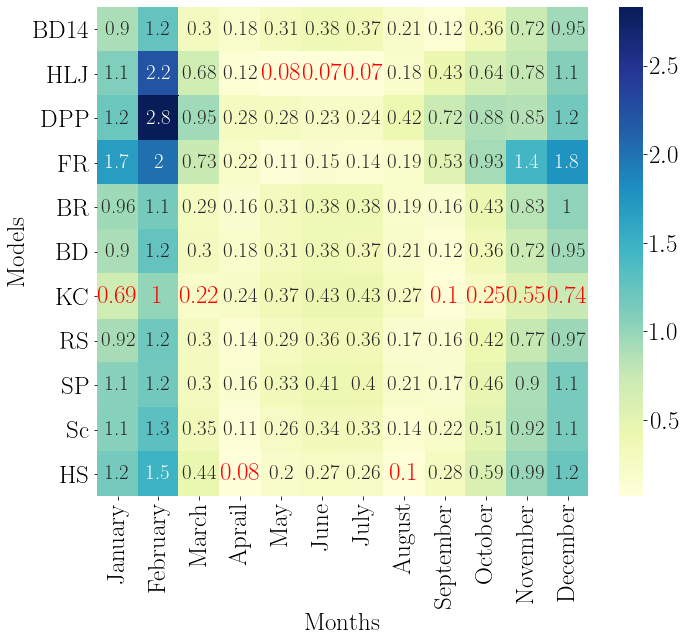

In [23]:
month = ['January','February','March','Aprail','May','June','July','August','September',
                               'October','November','December']
min_in_each_column = np.min(MSE_df, axis=0)
fig, ax = plt.subplots(figsize=(11, 9))
g = sns.heatmap(MSE_df, mask=MSE_df == min_in_each_column, annot = True, cmap="YlGnBu", xticklabels=month)
g = sns.heatmap(MSE_df, mask=MSE_df != min_in_each_column, annot_kws={'fontsize':25,'fontweight': 1000,'c':'r'},
                annot = True, cmap="YlGnBu",cbar = False,xticklabels=month)
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.ylabel('Models')
plt.xlabel('Months')
plt.savefig('RMSEheatmap.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show();

In [24]:
DateCounts = G_data.Date.value_counts()
G_data = G_data[G_data.Date.isin(DateCounts.index[DateCounts.gt(8)])]
G_data = G_data.reset_index(drop = True)

In [25]:
dates = G_data.Date.unique()
def month_date_sort(datesArray):
    complete = []
    for Date in datesArray:
        if len(Date.split('-')[1])==1:
            month = '0' + Date.split('-')[1]
        else:
            month = Date.split('-')[1]
        if len(Date.split('-')[2])==1:
            date = '0' + Date.split('-')[2]
        else:
            date = Date.split('-')[2]
        complete.append(month + date)
    sortedDates = [x for _, x in sorted(zip(complete, datesArray))]
    return sortedDates

sortedDates = month_date_sort(dates)
print(sortedDates)

['2011-5-19', '2011-5-23', '2011-5-24', '2011-5-28', '2011-5-30', '2013-6-20', '2013-6-22', '2010-7-10', '2009-9-15', '2009-9-17', '2009-9-18', '2009-9-28', '2009-10-2', '2009-10-3']


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


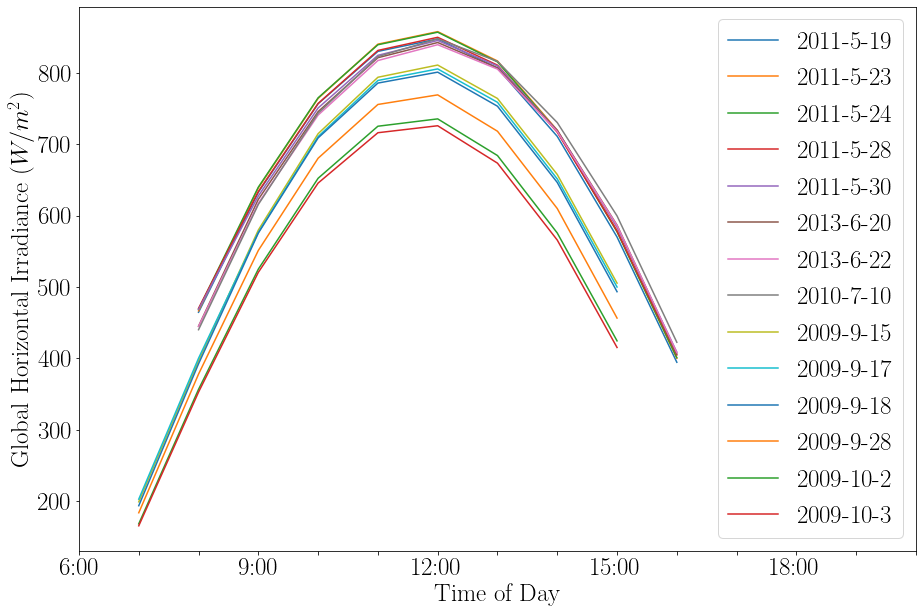

In [26]:
fig = plt.figure(figsize=(15,10))
hours = []
for i in range(24):
    if i<10:
        hours.append('0'+str(i)+':00')
    else:
        hours.append(str(i)+':00')
#x = range(13)
hourslabel = ['6:00','','','9:00','','','12:00','','','15:00','','','18:00']
for date in sortedDates:
    temp = G_data.loc[(G_data['Date'] == date)]
    temp = temp.reset_index(drop = True)
    values = []
    for hour in range(24):
        for i in range(len(temp)):
            if hour == temp.TimeStamp[i].hour:
                values.append(temp['GHI'][i])
                break
        else:
            values.append(np.nan)

    plt.plot(hours[6:21], values[6:21], label=date)
plt.xticks(hours[6:21], hourslabel)
plt.xlabel('Time of Day')
plt.ylabel('Global Horizontal Irradiance $(W/m^2)$') 
plt.legend()  

In [27]:
def getGHIValues(GHI_df):
    hours = []
    for i in range(24):
        if i<10:
            hours.append('0'+str(i)+':00')
        else:
            hours.append(str(i)+':00')
    DatewiseValue = []
    for date in sortedDates:
        temp = GHI_df.loc[(GHI_df['Date'] == date)]
        temp = temp.reset_index(drop = True)
        values = []
        for hour in range(24):
            for i in range(len(temp)):
                if hour == temp.TimeStamp[i].hour:
                    values.append(temp['GHI'][i])
                    break
            else:
                values.append(np.nan)
        DatewiseValue.append(values)
        
    return DatewiseValue

In [28]:
GHI_HLJ,DNI_HLJ,DHI_HLJ = HLJ(G_data,Elevation)
GHI_FR,DNI_FR,DHI_FR = FR(G_data,Elevation)
GHI_DPP,DNI_DPP,DHI_DPP = DPP(G_data)
GHI_BD = BD(G_data)
GHI_KC = KC(G_data)
GHI_RS = RS(G_data)
GHI_BD14 = BD14(G_data)
GHI_BR,DNI_BR,DHI_BR = BR(G_data)
GHI_Sc,DNI_Sc,DHI_Sc = Sc(G_data)
GHI_SP,DNI_SP,DHI_SP = SP(G_data)
GHI_HS,DNI_HS,DHI_HS = HS(G_data)

In [29]:
orig_df = getGHIValues(G_data)

HLJ_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_HLJ),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
FR1999_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_FR),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
DPP_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_DPP),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
BD_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_BD),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
KC1980_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_KC),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
BD2014_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_BD14),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
BR1979_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_BR),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
S1976_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_Sc),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))
SP1965_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_SP),list(G_data['Date']))),
    
                                      columns =['TimeStamp','GHI','Date']))
HS_df = getGHIValues(pd.DataFrame(list(zip(list(G_data['TimeStamp']),list(GHI_HS),list(G_data['Date']))),
            columns =['TimeStamp','GHI','Date']))


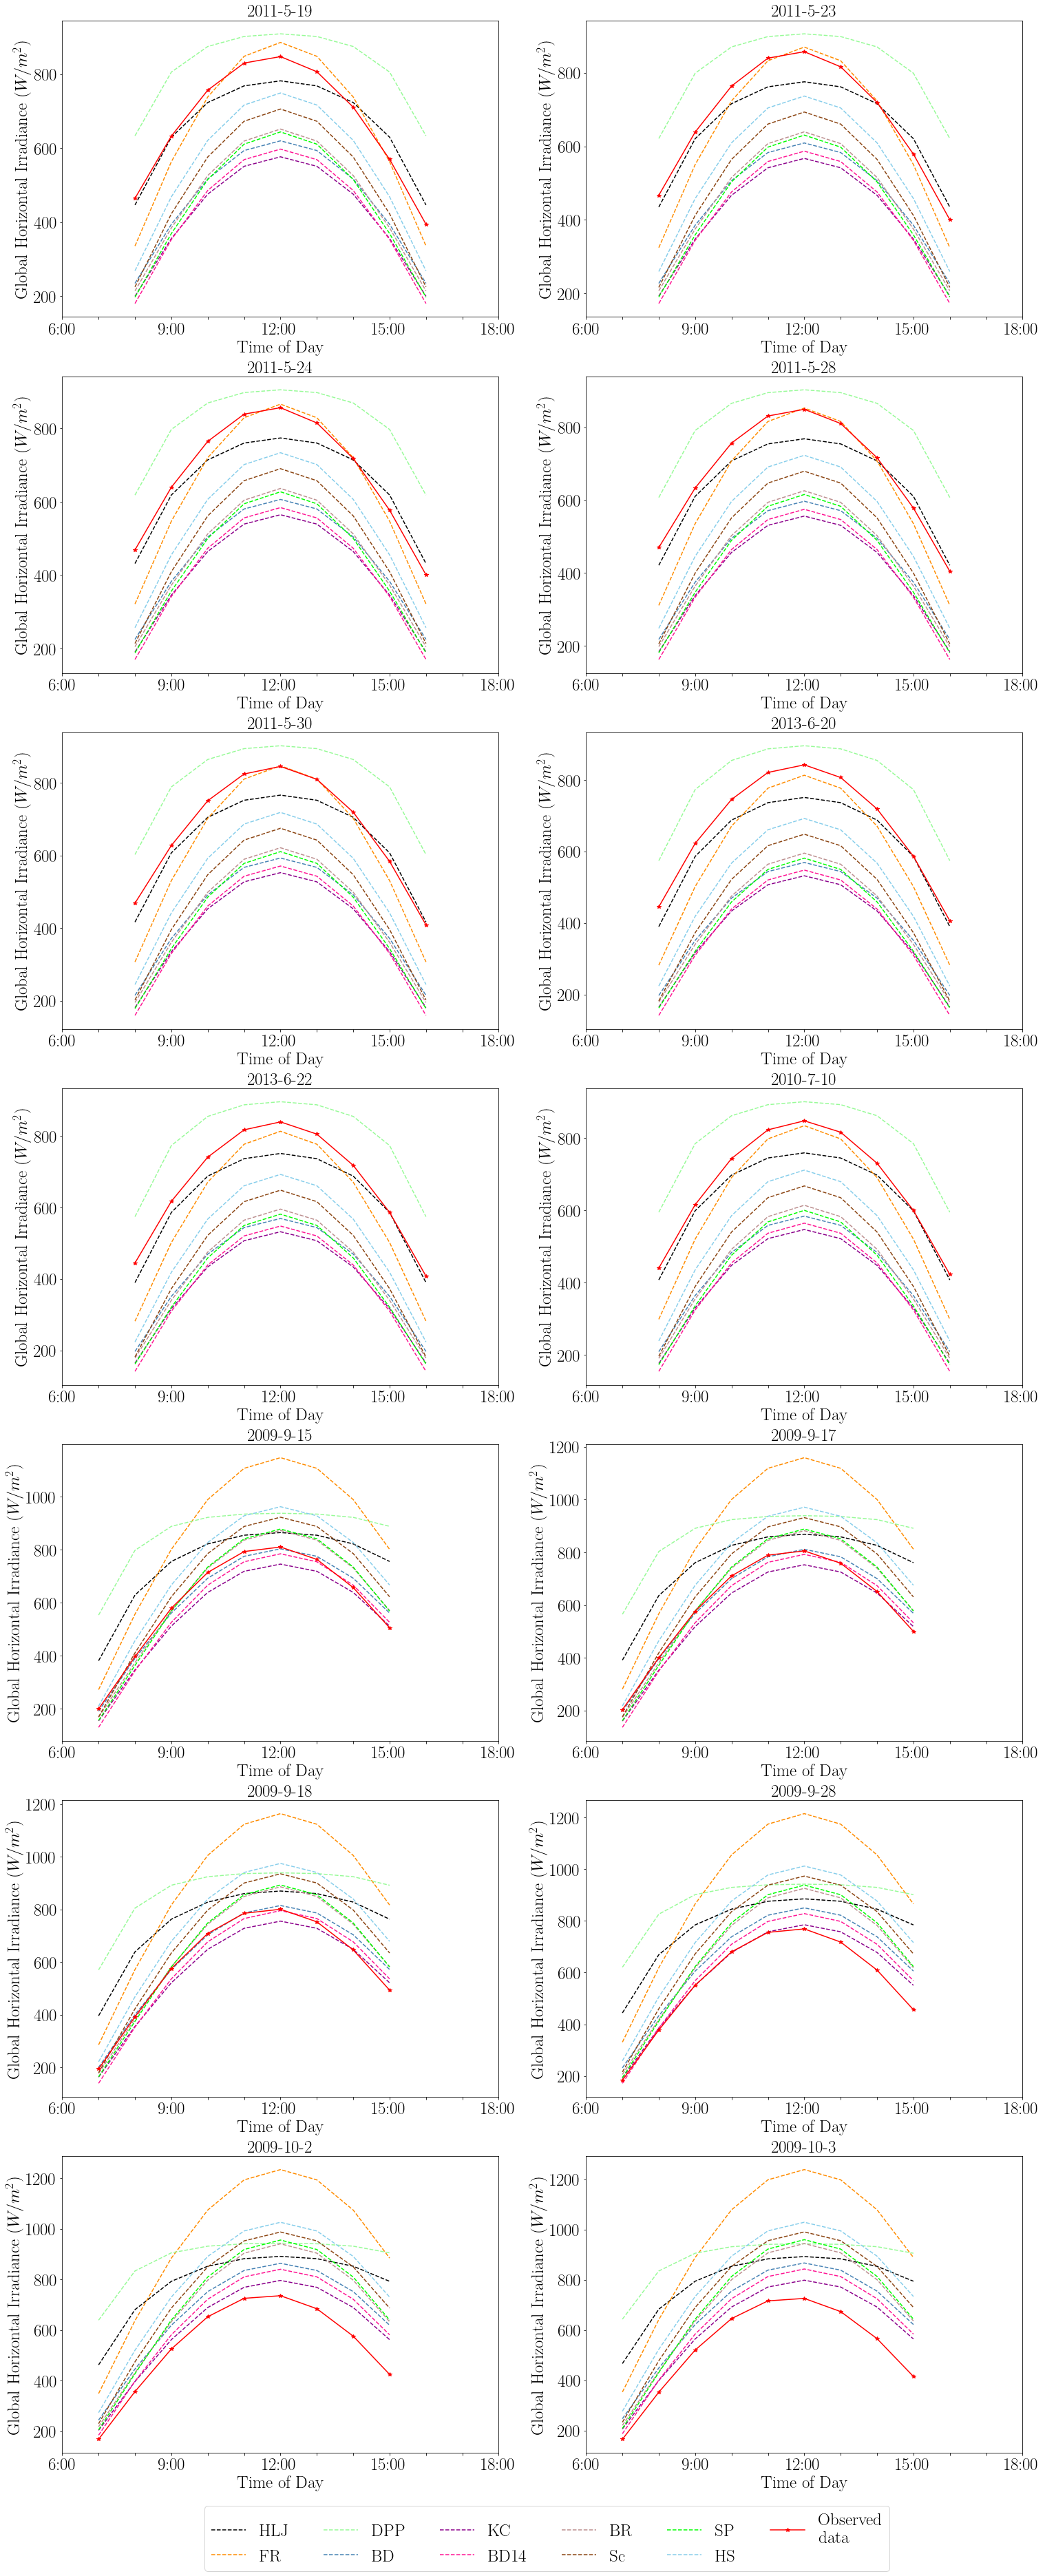

In [30]:
#  Categorical Data
a = 7  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(25,65))

hours = []
for i in range(24):
    if i<10:
        hours.append('0'+str(i)+':00')
    else:
        hours.append(str(i)+':00')
x = range(13)
hourslabel = ['6:00','','','9:00','','','12:00','','','15:00','','','18:00']
for i in range(len(orig_df)):
    plt.subplot(a, b, c)
    plt.title(sortedDates[i])
    
    plt.plot(x,HLJ_df[i][6:19],'black',linestyle='dashed',label = 'HLJ')
    plt.plot(x,FR1999_df[i][6:19],'darkorange',linestyle='dashed',label = 'FR')
    plt.plot(x,DPP_df[i][6:19],'palegreen',linestyle='dashed',label = 'DPP')
    plt.plot(x,BD_df[i][6:19],'steelblue',linestyle='dashed',label = 'BD')
    plt.plot(x,KC1980_df[i][6:19],'darkmagenta',linestyle='dashed',label = 'KC')
    plt.plot(x,BD2014_df[i][6:19],'deeppink',linestyle='dashed',label = 'BD14')
    plt.plot(x,BR1979_df[i][6:19],'rosybrown',linestyle='dashed',label = 'BR')
    plt.plot(x,S1976_df[i][6:19],'saddlebrown',linestyle='dashed',label = 'Sc')
    plt.plot(x,SP1965_df[i][6:19],'lime',linestyle='dashed',label = 'SP')
    plt.plot(x,HS_df[i][6:19],'skyblue',linestyle='dashed',label = 'HS')
    plt.plot(x,orig_df[i][6:19],'r-*', label = 'Observed \n data')
    c = c + 1
    plt.xticks(x, hourslabel)
    
    plt.xlabel('Time of Day')
    plt.ylabel('Global Horizontal Irradiance $(W/m^2)$') 
    #plt.legend(loc="upper left")
    
plt.legend(ncol=6,bbox_to_anchor=(-0.09, -0.15), loc="upper center")     
plt.savefig('ClearSkySortedDates.jpg')
plt.show()


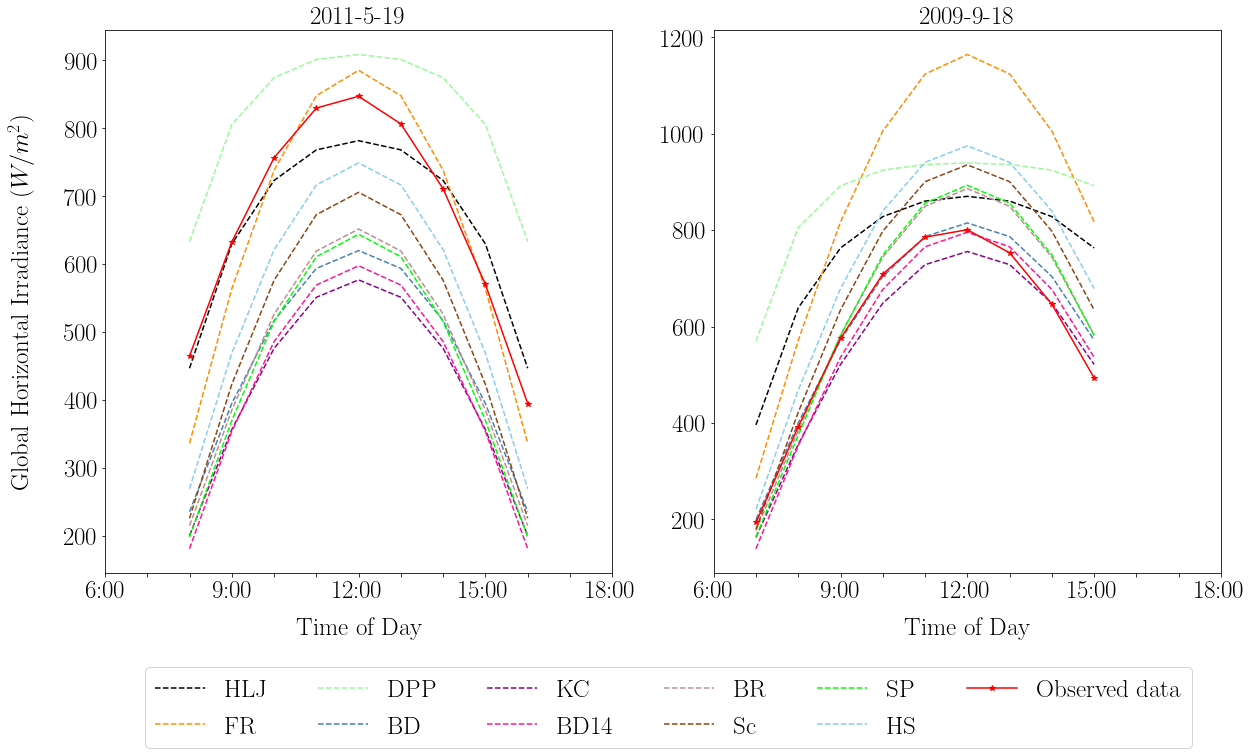

In [31]:
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
DatesInd = [sortedDates.index('2011-5-19'),sortedDates.index('2009-9-18')]

fig = plt.figure(figsize=(20,10))

hours = []
for i in range(24):
    if i<10:
        hours.append('0'+str(i)+':00')
    else:
        hours.append(str(i)+':00')
x = range(13)
hourslabel = ['6:00','','','9:00','','','12:00','','','15:00','','','18:00']
for i in range(len(DatesInd)):
    plt.subplot(a, b, c)
    plt.title(sortedDates[DatesInd[i]])
    
    plt.plot(x,HLJ_df[DatesInd[i]][6:19],'black',linestyle='dashed',label = 'HLJ')
    plt.plot(x,FR1999_df[DatesInd[i]][6:19],'darkorange',linestyle='dashed',label = 'FR')
    plt.plot(x,DPP_df[DatesInd[i]][6:19],'palegreen',linestyle='dashed',label = 'DPP')
    plt.plot(x,BD_df[DatesInd[i]][6:19],'steelblue',linestyle='dashed',label = 'BD')
    plt.plot(x,KC1980_df[DatesInd[i]][6:19],'darkmagenta',linestyle='dashed',label = 'KC')
    plt.plot(x,BD2014_df[DatesInd[i]][6:19],'deeppink',linestyle='dashed',label = 'BD14')
    plt.plot(x,BR1979_df[DatesInd[i]][6:19],'rosybrown',linestyle='dashed',label = 'BR')
    plt.plot(x,S1976_df[DatesInd[i]][6:19],'saddlebrown',linestyle='dashed',label = 'Sc')
    plt.plot(x,SP1965_df[DatesInd[i]][6:19],'lime',linestyle='dashed',label = 'SP')
    plt.plot(x,HS_df[DatesInd[i]][6:19],'skyblue',linestyle='dashed',label = 'HS')
    plt.plot(x,orig_df[DatesInd[i]][6:19],'r-*', label = 'Observed data')
    c = c + 1
    plt.xticks(x, hourslabel)
    
    plt.xlabel('Time of Day',labelpad= 15)
    if (i!=1):
        plt.ylabel('Global Horizontal Irradiance $(W/m^2)$',labelpad= 30) 
    else:
        break;
plt.legend(ncol=6,bbox_to_anchor=(-0.09, -0.15), loc="upper center")  
plt.savefig('maySep.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show()
